## Extraindo as descrições dos workflows

In [1]:
from collections import Counter

def verificaPalavra(texto):
    # Concatenar os vetores em uma única lista
    texto = " ".join(texto).split()
    todos_os_vetores = corpus_trated
    
    # Dividir as frases em palavras e criar um conjunto de palavras únicas
    palavras_unicas = set()
    todas_as_palavras = []
    
    for frase in todos_os_vetores:
        palavras = frase.split()
        todas_as_palavras.extend(palavras)
        palavras_unicas.update(palavras)
    
    # Contar a frequência de cada palavra em todas as frases
    contagem = Counter(todas_as_palavras)
    
    # Filtrar as palavras que aparecem apenas uma vez em todas as frases
    palavras_unicas = {palavra for palavra, frequencia in contagem.items() if frequencia == 1}
    
    # Criar novos vetores com palavras únicas
    vetorNovo = []
    for palavra in texto:
        if palavra in palavras_unicas:
            vetorNovo.append(palavra)
    return(vetorNovo)

In [2]:
import os
from bs4 import BeautifulSoup
from lxml import etree
import unicodedata
import utils

corpus = []

for file_name in os.listdir("..\\workflows_myExperiment"):
    file_path = f'..\\workflows_myExperiment\\{file_name}\\{file_name}.html'
    if(os.path.exists(file_path)):
        with open(file_path, 'r', encoding="utf8") as html:
            html_content = html.read()
            soup = BeautifulSoup(html_content, 'html.parser')
            dom = etree.HTML(str(soup))
            target_element = dom.xpath("//div[@class='contribution_description']/p//text()")
            if target_element:
                extracted_text = "".join(target_element)
                #print(file_name)
                corpus.append(extracted_text)

In [3]:
len(corpus)

2525

In [4]:
corpus_trated = [utils.normalize_text(x,stopwords = True, steemer = True) for x in corpus]

## TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus_trated)
vectorizer.get_feature_names_out()

array(['aa', 'aac', 'aapfco', ..., 'zwr', 'zwyczajny', 'zwyk'],
      dtype=object)

In [6]:
X.shape

(2525, 9512)

## TF-IDF PCA

In [7]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
corpus_pca = pca.fit_transform(X.toarray())

In [8]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.01163412 0.01016648 0.00929088]
[5.37474513 5.02430946 4.80307626]


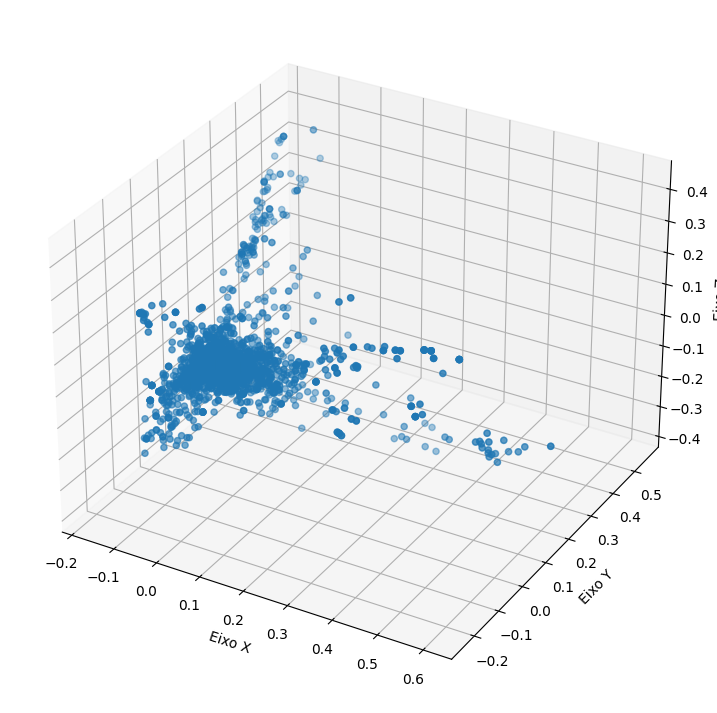

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

#ex_variance=np.var(X_pca,axis=0)
#ex_variance_ratio = ex_variance/np.sum(ex_variance)
#ex_variance_ratio

Xax = corpus_pca[:,0]
Yax = corpus_pca[:,1]
Zax = corpus_pca[:,2]


fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(Xax, Yax, Zax)

# Defina rótulos para os eixos
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')

# Mostre o gráfico
plt.show()

## MeanShift TF-IDF

In [10]:
from sklearn.cluster import MeanShift
bandwidth_tfidf = 0.18
ms_tfidf = MeanShift(bandwidth=bandwidth_tfidf)
ms_tfidf.fit(corpus_pca) 
np.unique(ms_tfidf.labels_)

array([0, 1, 2, 3], dtype=int64)

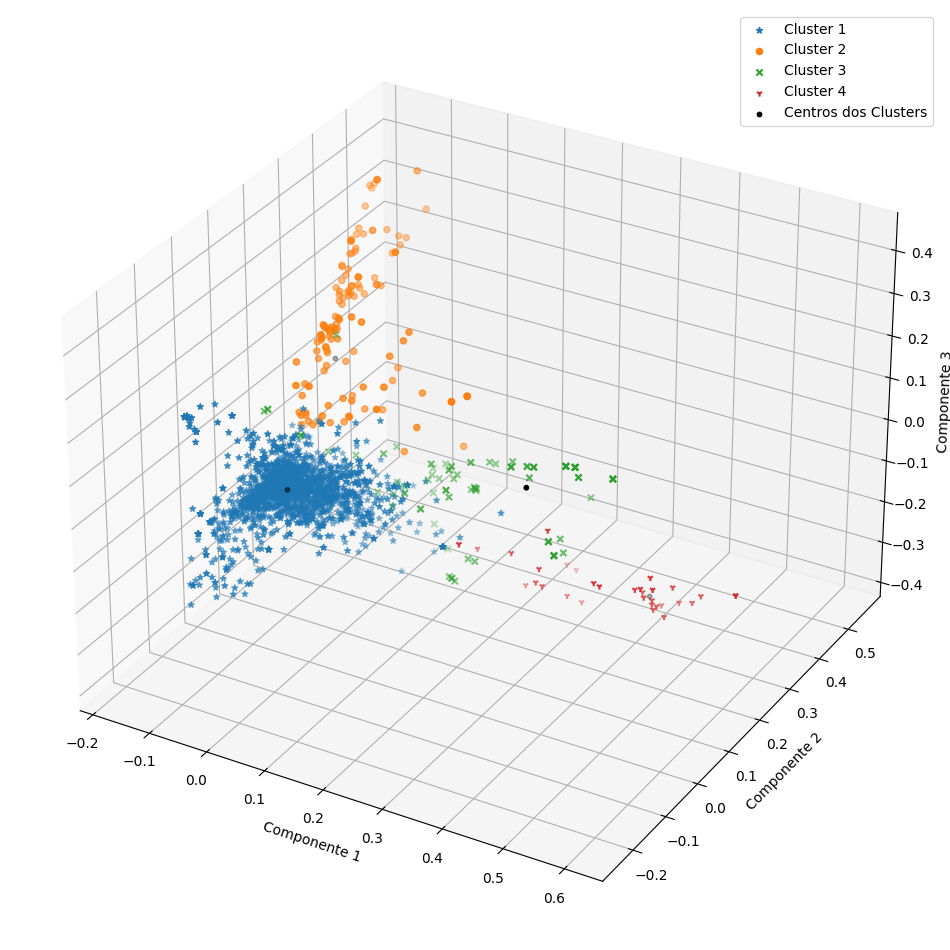

In [11]:
#Cluster para cada observação
labels = ms_tfidf.labels_

#Centro de cada cluster
cluster_centers = ms_tfidf.cluster_centers_

#Verifica quantos clusters foram encontrados
n_clusters = len(np.unique(labels))

fig = plt.figure(figsize=(12, 20))
ax = fig.add_subplot(projection='3d')

marker={0:'*',1:'o',2:'x',3:'1',4:'2',5:'3',6:'4',7:'p',8:'s'}
for i in range(n_clusters):
    cluster = corpus_pca[labels == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f'Cluster {i + 1}',marker=marker[i])

ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2],
           s=10, color='black', label='Centros dos Clusters')

# Defina rótulos para os eixos
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

# Adicione uma legenda
ax.legend()

# Mostre o gráfico
plt.show()

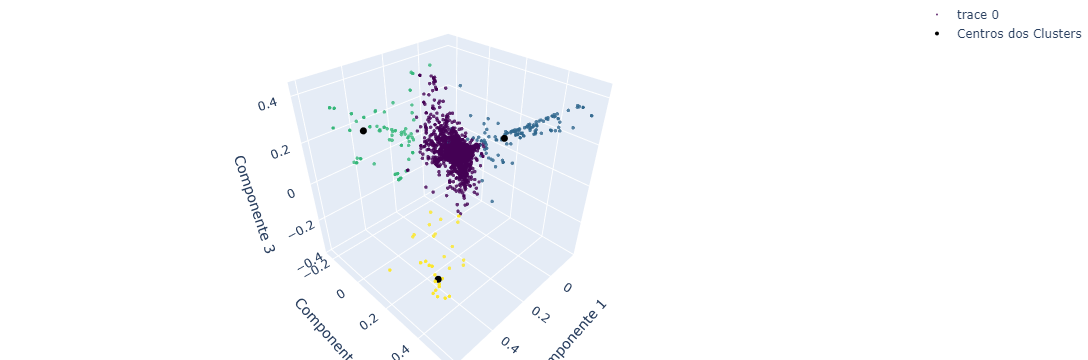

In [12]:
import plotly.graph_objs as go
from sklearn.cluster import MeanShift

# Criar um gráfico 3D interativo com Plotly
trace1 = go.Scatter3d(
    x= corpus_pca[:, 0],
    y= corpus_pca[:, 1],
    z= corpus_pca[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        opacity=0.8,
        color=labels,  # Cor por rótulo de cluster
        colorscale='Viridis',  # Escolha de cores
    ),
    text=labels,  # Rótulos de texto com base nos rótulos de cluster
)

trace2 = go.Scatter3d(
    x=cluster_centers[:, 0],
    y=cluster_centers[:, 1],
    z=cluster_centers[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        symbol='circle',
        opacity=1,
        color='black',  # Cor dos centros dos clusters
    ),
    name='Centros dos Clusters',
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Componente 1'),
        yaxis=dict(title='Componente 2'),
        zaxis=dict(title='Componente 3'),
    ),
)

data = [trace1, trace2]

fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico interativo no notebook ou em um arquivo HTML
fig.show(renderer = "jupyterlab")

Cluster: 0  range: [0-2241)


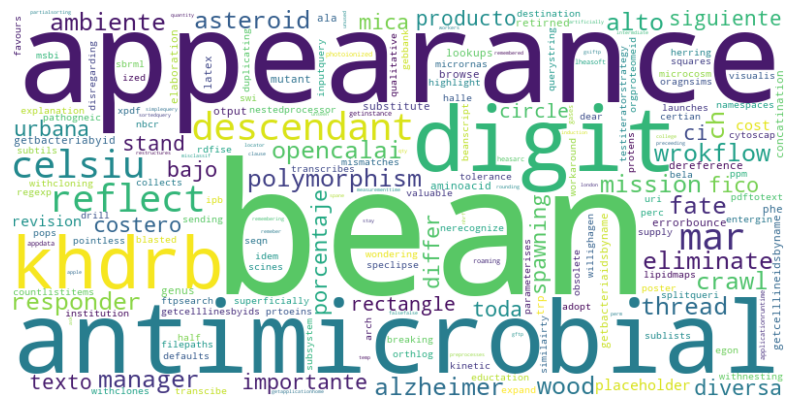

Cluster: 1  range: [2241-2384)


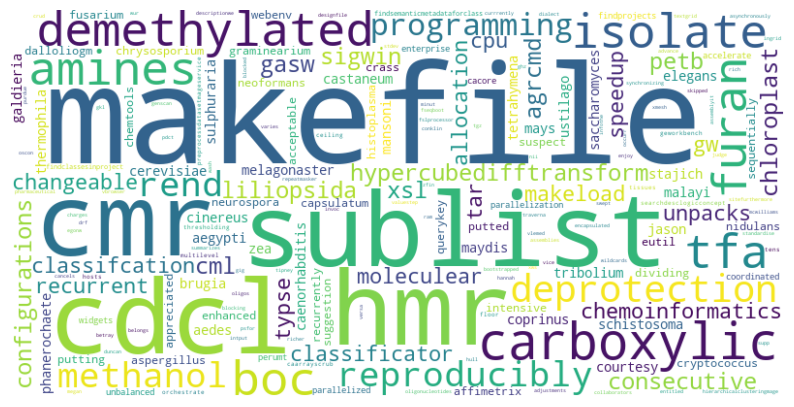

Cluster: 2  range: [2384-2475)


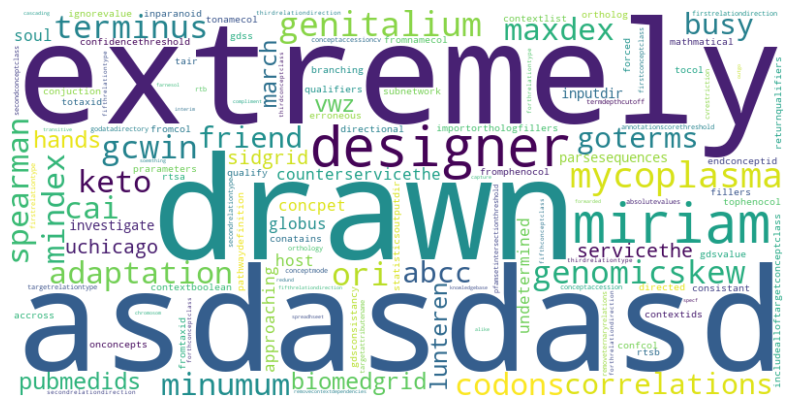

Cluster: 3  range: [2475-2525)


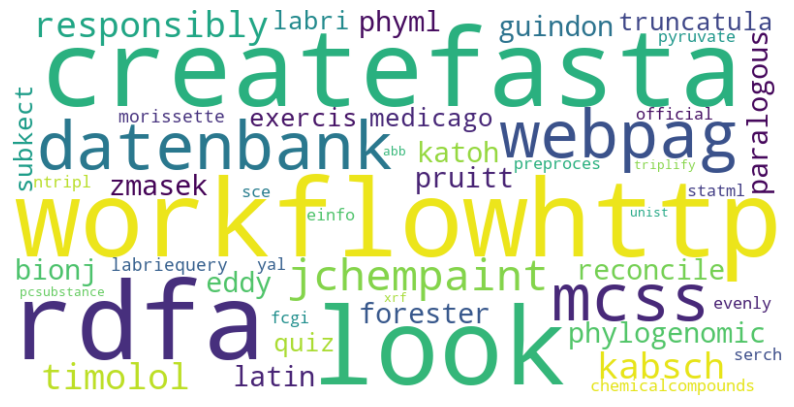

In [13]:
from wordcloud import WordCloud
li = 0
ls = 0
for i in range(n_clusters):
    range_cluster = len(corpus_pca[labels == i])
    ls = li + range_cluster
    print(f'Cluster: {i}  range: [{li}-{ls})')
    #wordcloud = WordCloud(width=800, height=400, background_color="white").generate(''.join(corpus_trated[li:ls]))
    wordcloud = WordCloud(width=800, height=400, background_color="white",collocations=False).generate(" ".join(verificaPalavra(corpus_trated[li:ls])))

    # Exiba a nuvem de palavras
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    li = ls

## Word2Vec

In [14]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Carregue o modelo Word2Vec pré-treinado
w2vmodel = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)


In [15]:
w2vmean = []
nomatch = 0
match = 0
for phrase in corpus_trated:
    phrase = phrase.split()
    w2vsum = np.zeros(300)
    if len(phrase) > 0:
        for word in phrase:
            try:
                w2vsum = w2vsum + w2vmodel[word]
                match += 1
            except KeyError:
                nomatch += 1
        w2vmean.append(w2vsum/len(phrase))
print(f'Matches: {match} => {match/(match+nomatch)}')
print(f'No Matches: {nomatch} => {nomatch/(match+nomatch)}')

Matches: 74282 => 0.8530904747685877
No Matches: 12792 => 0.14690952523141237


## Word2Vec PCA

In [16]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
corpus_pca_w2v = pca.fit_transform(w2vmean)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.10207423 0.08062671 0.05682631]
[14.79058931 13.14519111 11.0357574 ]


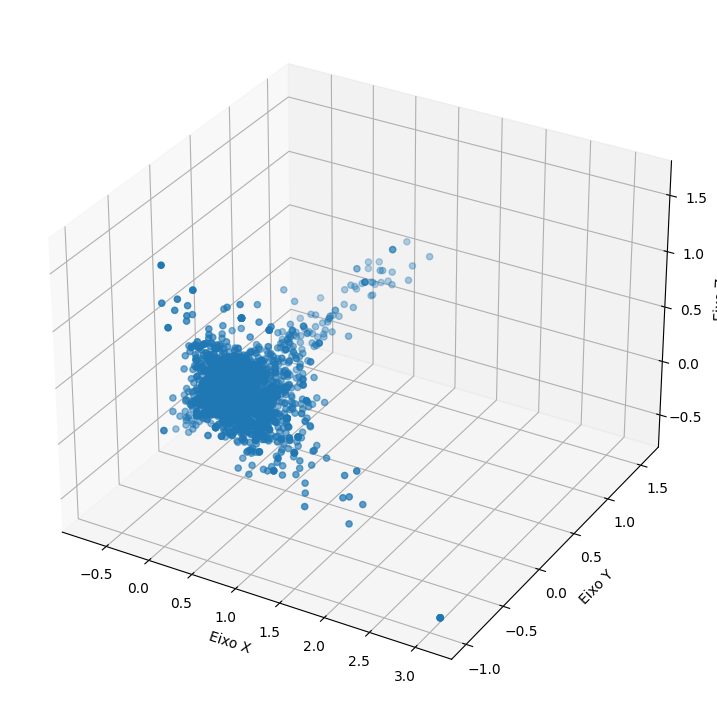

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

Xax = corpus_pca_w2v[:,0]
Yax = corpus_pca_w2v[:,1]
Zax = corpus_pca_w2v[:,2]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(Xax, Yax, Zax)

# Defina rótulos para os eixos
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')

# Mostre o gráfico
plt.show()

## MeanShift Word2Vec

In [18]:
from sklearn.cluster import MeanShift
bandwidth_w2v = 0.45
ms_w2v = MeanShift(bandwidth=bandwidth_w2v)
ms_w2v.fit(corpus_pca_w2v) 
np.unique(ms_w2v.labels_)

array([0, 1, 2, 3, 4, 5], dtype=int64)

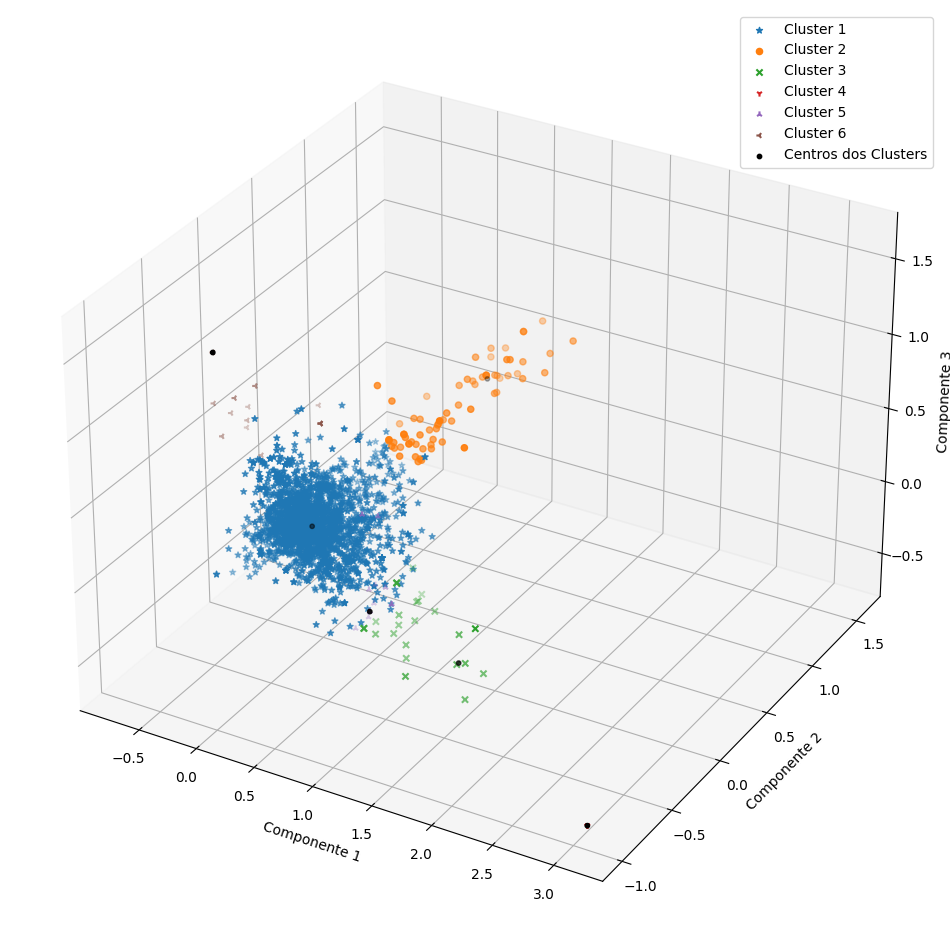

In [19]:
#Cluster para cada observação
labels = ms_w2v.labels_

#Centro de cada cluster
cluster_centers = ms_w2v.cluster_centers_

#Verifica quantos clusters foram encontrados
n_clusters = len(np.unique(labels))

fig = plt.figure(figsize=(12, 20))
ax = fig.add_subplot(projection='3d')

marker={0:'*',1:'o',2:'x',3:'1',4:'2',5:'3',6:'4',7:'p',8:'s'}
for i in range(n_clusters):
    cluster = corpus_pca_w2v[labels == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f'Cluster {i + 1}',marker=marker[i])

ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2],
           s=10, color='black', label='Centros dos Clusters')

# Defina rótulos para os eixos
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

# Adicione uma legenda
ax.legend()

# Mostre o gráfico
plt.show()

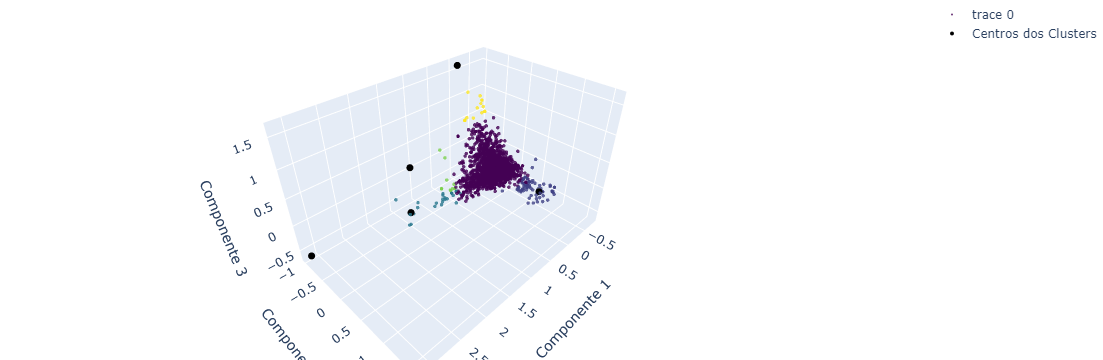

In [20]:
import plotly.graph_objs as go
from sklearn.cluster import MeanShift

# Criar um gráfico 3D interativo com Plotly
trace1 = go.Scatter3d(
    x= corpus_pca_w2v[:, 0],
    y= corpus_pca_w2v[:, 1],
    z= corpus_pca_w2v[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        opacity=0.8,
        color=labels,  # Cor por rótulo de cluster
        colorscale='Viridis',  # Escolha de cores
    ),
    text=labels,  # Rótulos de texto com base nos rótulos de cluster
)

trace2 = go.Scatter3d(
    x=cluster_centers[:, 0],
    y=cluster_centers[:, 1],
    z=cluster_centers[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        symbol='circle',
        opacity=1,
        color='black',  # Cor dos centros dos clusters
    ),
    name='Centros dos Clusters',
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Componente 1'),
        yaxis=dict(title='Componente 2'),
        zaxis=dict(title='Componente 3'),
    ),
)

data = [trace1, trace2]

fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico interativo no notebook ou em um arquivo HTML
fig.show(renderer = "jupyterlab")

Cluster: 0  range: [0-2379)


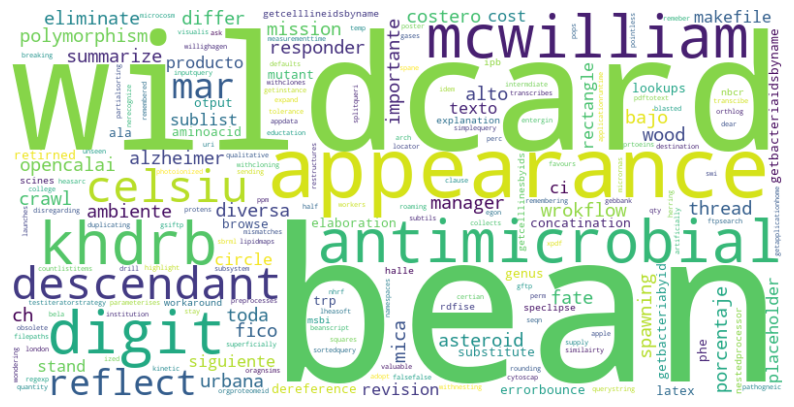

Cluster: 1  range: [2379-2455)


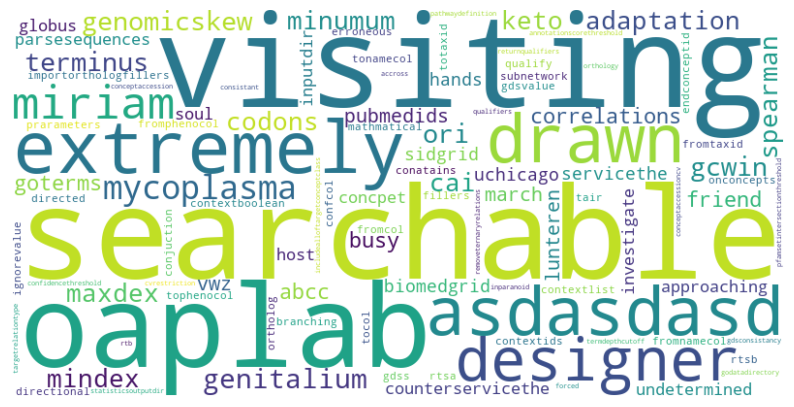

Cluster: 2  range: [2455-2484)


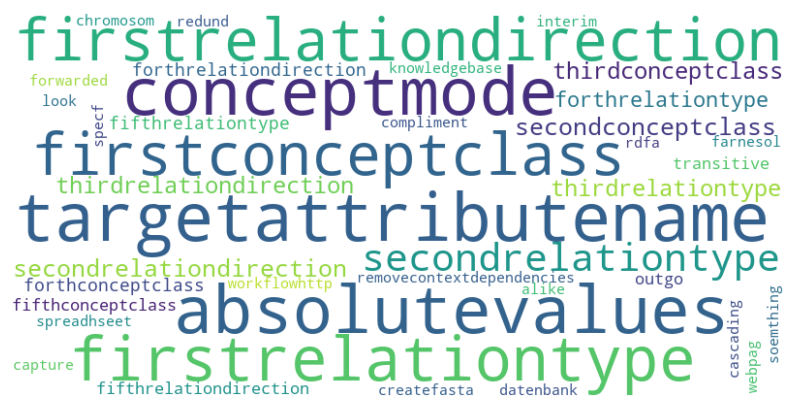

Cluster: 3  range: [2484-2487)


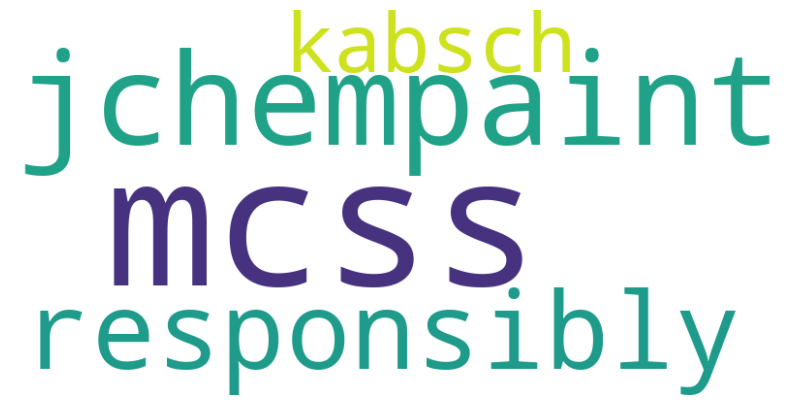

Cluster: 4  range: [2487-2500)


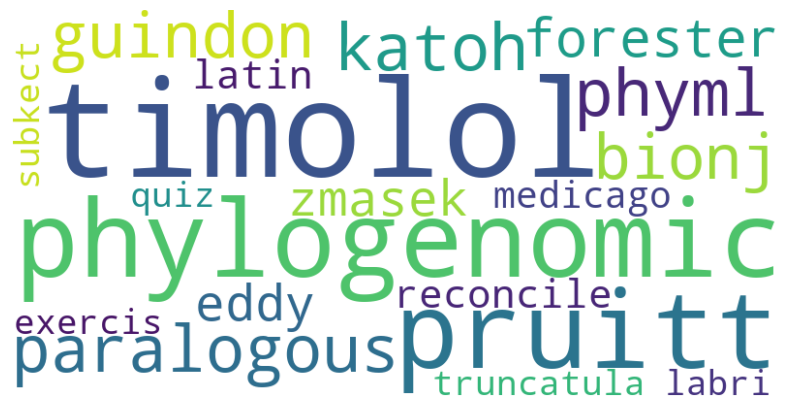

Cluster: 5  range: [2500-2520)


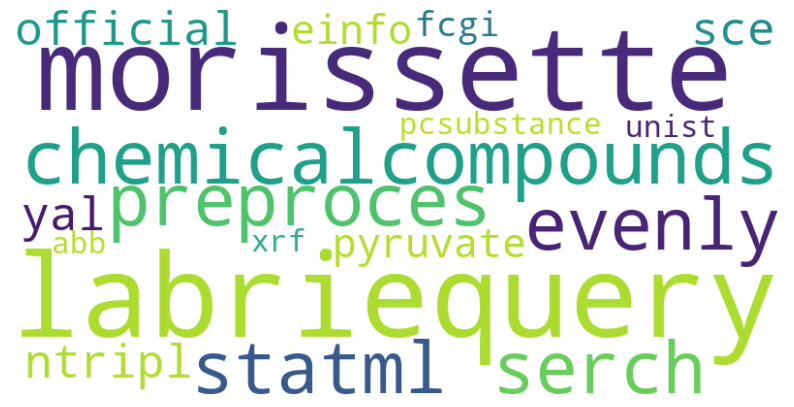

In [21]:
from wordcloud import WordCloud
li = 0
ls = 0
for i in range(n_clusters):
    range_cluster = len(corpus_pca_w2v[labels == i])
    ls = li + range_cluster
    print(f'Cluster: {i}  range: [{li}-{ls})')
    #wordcloud = WordCloud(width=800, height=400, background_color="white").generate(''.join(corpus_trated[li:ls]))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(verificaPalavra(corpus_trated[li:ls])))

    # Exiba a nuvem de palavras
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    li = ls

## FastText

In [53]:
from gensim.models import FastText

tokenized_corpus = [text.split() for text in corpus_trated]

ftmodel = FastText(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, sg=1)

ftmodel.train(tokenized_corpus, total_examples=len(tokenized_corpus), epochs=1000)

(80126047, 87074000)

In [54]:
ftmean = []
nomatch = 0
match = 0
for phrase in corpus_trated:
    phrase = phrase.split()
    ftsum = np.zeros(100)
    if len(phrase) > 0:
        for word in phrase:
            try:
                ftsum = ftsum + ftmodel.wv[word]
                match += 1
            except KeyError:
                nomatch += 1
        ftmean.append(ftsum/len(phrase))
print(f'Matches: {match} => {match/(match+nomatch)}')
print(f'No Matches: {nomatch} => {nomatch/(match+nomatch)}')

Matches: 87074 => 1.0
No Matches: 0 => 0.0


## FastText PCA

In [55]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
corpus_pca_ft = pca.fit_transform(ftmean)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.0606876  0.0565908  0.03964842]
[37.10634659 35.83200667 29.99239676]


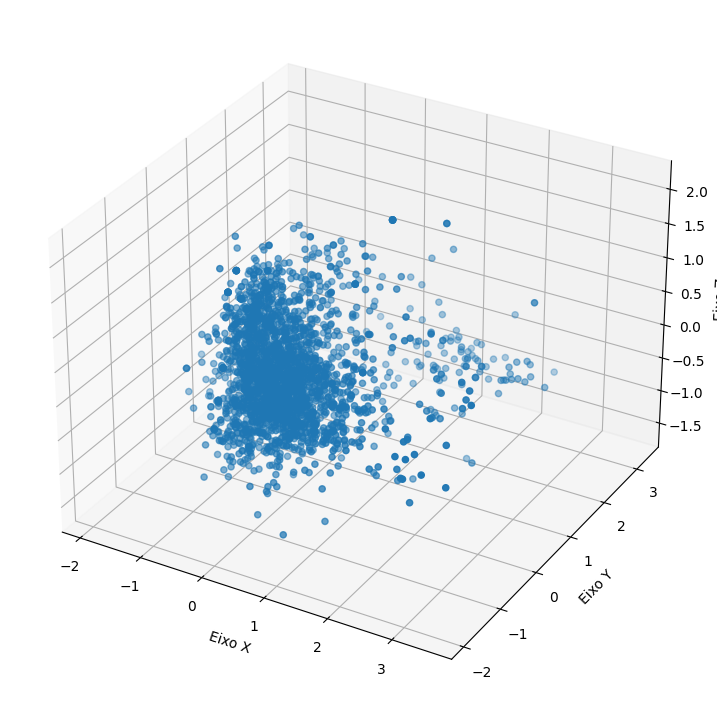

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

Xax = corpus_pca_ft[:,0]
Yax = corpus_pca_ft[:,1]
Zax = corpus_pca_ft[:,2]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(Xax, Yax, Zax)

# Defina rótulos para os eixos
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')

# Mostre o gráfico
plt.show()

## FastText MeanShift

In [57]:
from sklearn.cluster import MeanShift
bandwidth_ft = 0.9
ms_ft = MeanShift(bandwidth=bandwidth_ft)
ms_ft.fit(corpus_pca_ft) 
np.unique(ms_ft.labels_)

array([0, 1, 2, 3, 4, 5], dtype=int64)

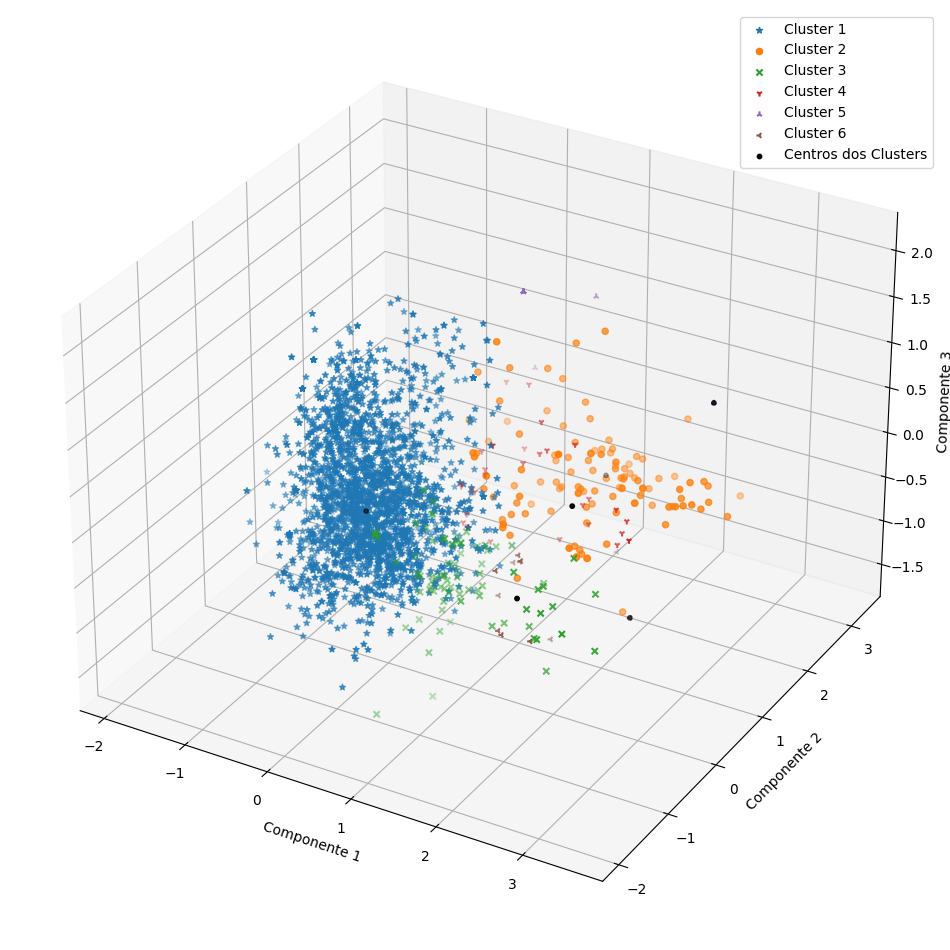

In [58]:
#Cluster para cada observação
labels = ms_ft.labels_

#Centro de cada cluster
cluster_centers = ms_ft.cluster_centers_

#Verifica quantos clusters foram encontrados
n_clusters = len(np.unique(labels))

fig = plt.figure(figsize=(12, 20))
ax = fig.add_subplot(projection='3d')

marker={0:'*',1:'o',2:'x',3:'1',4:'2',5:'3',6:'4',7:'p',8:'s'}
for i in range(n_clusters):
    cluster = corpus_pca_ft[labels == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f'Cluster {i + 1}',marker=marker[i])

ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2],
           s=10, color='black', label='Centros dos Clusters')

# Defina rótulos para os eixos
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

# Adicione uma legenda
ax.legend()

# Mostre o gráfico
plt.show()

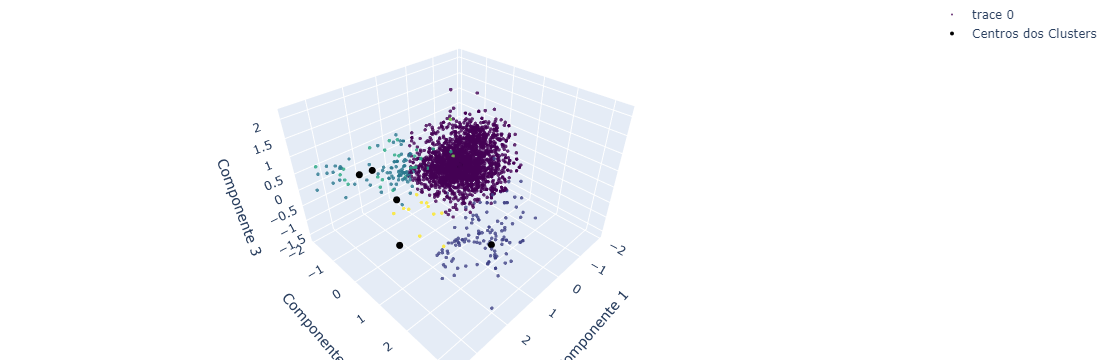

In [59]:
import plotly.graph_objs as go
from sklearn.cluster import MeanShift

# Criar um gráfico 3D interativo com Plotly
trace1 = go.Scatter3d(
    x= corpus_pca_ft[:, 0],
    y= corpus_pca_ft[:, 1],
    z= corpus_pca_ft[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        opacity=0.8,
        color=labels,  # Cor por rótulo de cluster
        colorscale='Viridis',  # Escolha de cores
    ),
    text=labels,  # Rótulos de texto com base nos rótulos de cluster
)

trace2 = go.Scatter3d(
    x=cluster_centers[:, 0],
    y=cluster_centers[:, 1],
    z=cluster_centers[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        symbol='circle',
        opacity=1,
        color='black',  # Cor dos centros dos clusters
    ),
    name='Centros dos Clusters',
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Componente 1'),
        yaxis=dict(title='Componente 2'),
        zaxis=dict(title='Componente 3'),
    ),
)

data = [trace1, trace2]

fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico interativo no notebook ou em um arquivo HTML
fig.show(renderer = "jupyterlab")

Cluster: 0  range: [0-2243)


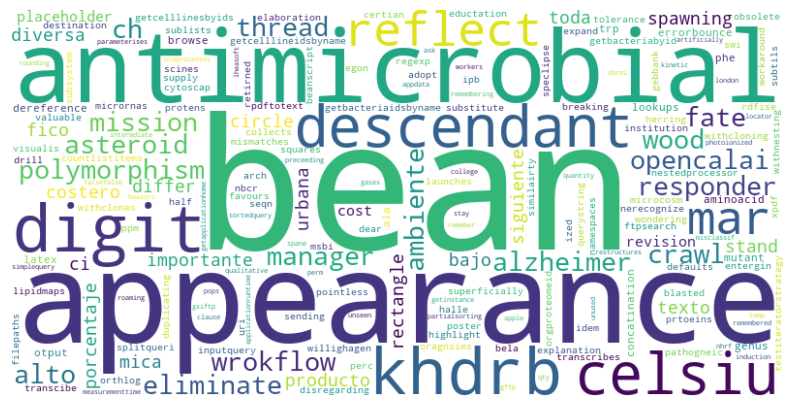

Cluster: 1  range: [2243-2374)


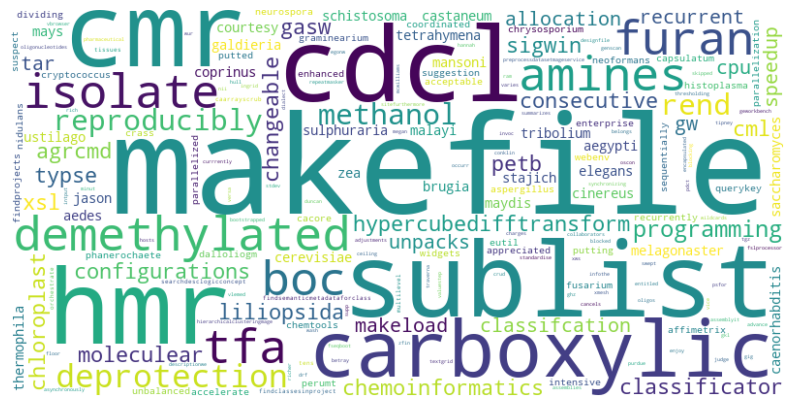

Cluster: 2  range: [2374-2469)


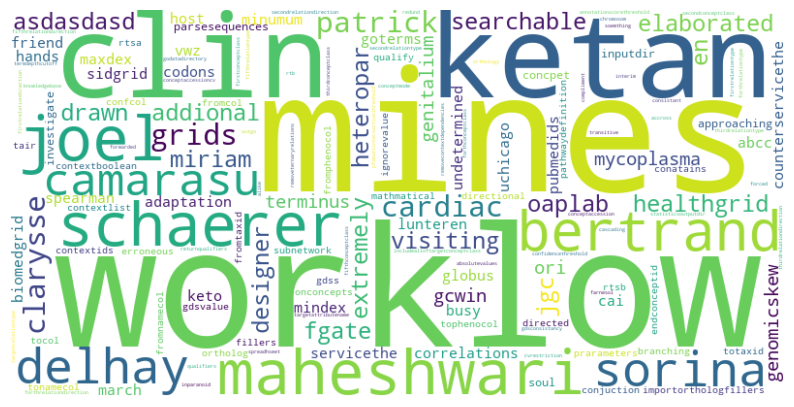

Cluster: 3  range: [2469-2498)


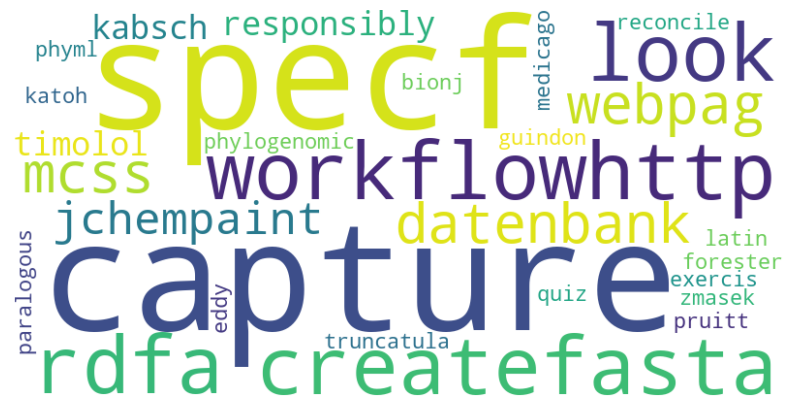

Cluster: 4  range: [2498-2508)


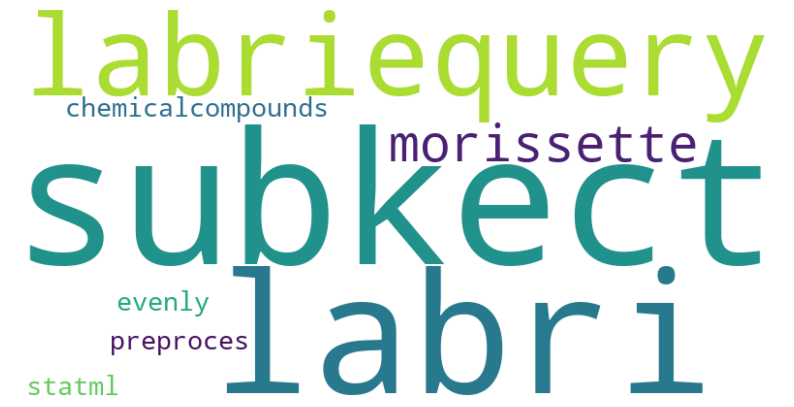

Cluster: 5  range: [2508-2520)


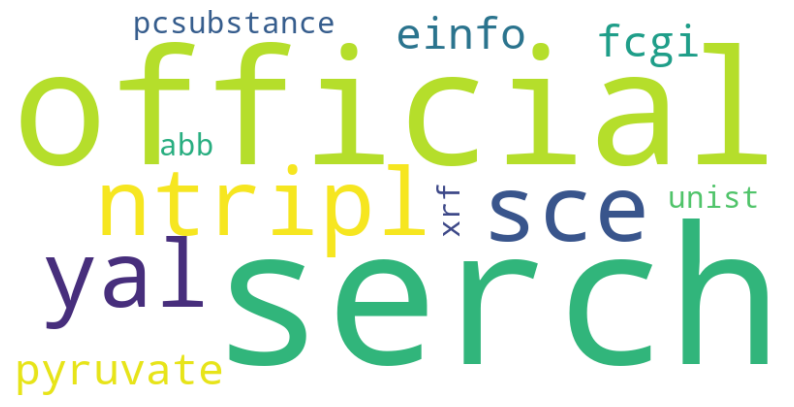

In [60]:
from wordcloud import WordCloud
li = 0
ls = 0
for i in range(n_clusters):
    range_cluster = len(corpus_pca_ft[labels == i])
    ls = li + range_cluster
    print(f'Cluster: {i}  range: [{li}-{ls})')
    #wordcloud = WordCloud(width=800, height=400, background_color="white").generate(''.join(corpus_trated[li:ls]))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(verificaPalavra(corpus_trated[li:ls])))

    # Exiba a nuvem de palavras
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    li = ls